In [1]:
# necessary import 
from pyspark.sql import SparkSession
# from pyspark.ml.image import ImageSchema
from sparkdl import readImages
from pyspark.sql.functions import lit
from functools import reduce
# create a spark session
spark = SparkSession.builder.appName("spark").getOrCreate()
# loaded image

print(spark)

# img_dir = "plant_dataset"
# apples_df = spark.read.format("image").load(img_dir + "/APPLE/HEALTHY").withColumn("label", lit("apple"))
# apricot_df = spark.read.format("image").load(img_dir + "/APRICOT/HEALTHY").withColumn("label", lit("apricot"))
# cherry_df = spark.read.format("image").load(img_dir + "/CHERRY/HEALTHY").withColumn("label", lit("cherry"))
# cranberry_df = spark.read.format("image").load(img_dir + "/CRANBERRY/HEALTHY").withColumn("label", lit("cranberry"))
# grapes_df = spark.read.format("image").load(img_dir + "/GRAPES/HEALTHY").withColumn("label", lit("grapes"))
# peach_df = spark.read.format("image").load(img_dir + "/PEACH/HEALTHY").withColumn("label", lit("peach"))
# pear_df = spark.read.format("image").load(img_dir + "/PEAR/HEALTHY").withColumn("label", lit("pear"))
# walnut_df = spark.read.format("image").load(img_dir + "/WALNUT/HEALTHY").withColumn("label", lit("walnut"))


img_dir = "plant_dataset"
apples_df = readImages(img_dir + "/APPLE/HEALTHY").withColumn("label", lit("apple"))
apricot_df = readImages(img_dir + "/APRICOT/HEALTHY").withColumn("label", lit("apricot"))
cherry_df = readImages(img_dir + "/CHERRY/HEALTHY").withColumn("label", lit("cherry"))
cranberry_df = readImages(img_dir + "/CRANBERRY/HEALTHY").withColumn("label", lit("cranberry"))
grapes_df = readImages(img_dir + "/GRAPES/HEALTHY").withColumn("label", lit("grapes"))
peach_df = readImages(img_dir + "/PEACH/HEALTHY").withColumn("label", lit("peach"))
pear_df = readImages(img_dir + "/PEAR/HEALTHY").withColumn("label", lit("pear"))
walnut_df = readImages(img_dir + "/WALNUT/HEALTHY").withColumn("label", lit("walnut"))


dataframes = [apples_df, apricot_df, cherry_df, cranberry_df, grapes_df,
             peach_df, pear_df, walnut_df]

# merge data frame
df = reduce(lambda first, second: first.union(second), dataframes)
# repartition dataframe 
df = df.repartition(200)


# split the data-frame
train, test = df.randomSplit([0.8, 0.2], 42)

Using TensorFlow backend.


In [2]:
display(apples_df)

DataFrame[filePath: string, image: struct<mode:string,height:int,width:int,nChannels:int,data:binary>, label: string]

In [1]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from sparkdl import DeepImageFeaturizer
import tensorflow as tf
from tensorflow import keras

# model: InceptionV3
# extracting feature from images
featurizer = DeepImageFeaturizer(inputCol="image",
                                 outputCol="features",
                                 modelName="InceptionV3")
                                 
# used as a multi class classifier
lr = LogisticRegression(maxIter=5, regParam=0.03, 
                        elasticNetParam=0.5, labelCol="label")




# define a pipeline model
sparkdn = Pipeline(stages=[featurizer, lr])
spark_model = sparkdn.fit(train)

Using TensorFlow backend.


In [2]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# evaluate the model with test set
evaluator = MulticlassClassificationEvaluator() 
tx_test = spark_model.transform(test)
print('F1-Score ', evaluator.evaluate(tx_test, 
                                      {evaluator.metricName: 'f1'}))
print('Precision ', evaluator.evaluate(tx_test,
                                       {evaluator.metricName:                    'weightedPrecision'}))
print('Recall ', evaluator.evaluate(tx_test, 
                                    {evaluator.metricName: 'weightedRecall'}))
print('Accuracy ', evaluator.evaluate(tx_test, 
                                      {evaluator.metricName: 'accuracy'}))

F1-Score  0.8111782234361806.
Precision  0.8422058244785519
Recall  0.8090909090909091
Accuracy  0.8090909090909091


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.GnBu):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
   
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
from sklearn.metrics import confusion_matrix
y_true = ["apples_df", "apricot_df", "cherry_df", "cranberry_df", "grapes_df",
             "peach_df", "pear_df", "walnut_df"]

y_pred = ["apples_df", "pear_df", "cherry_df", "cranberry_df", "grapes_df",
             "peach_df", "pear_df", "walnut_df"]

cnf_matrix = confusion_matrix(y_true, y_pred,labels=["apples_df", "apricot_df", "cherry_df", "cranberry_df", "grapes_df",
             "peach_df", "pear_df", "walnut_df"])

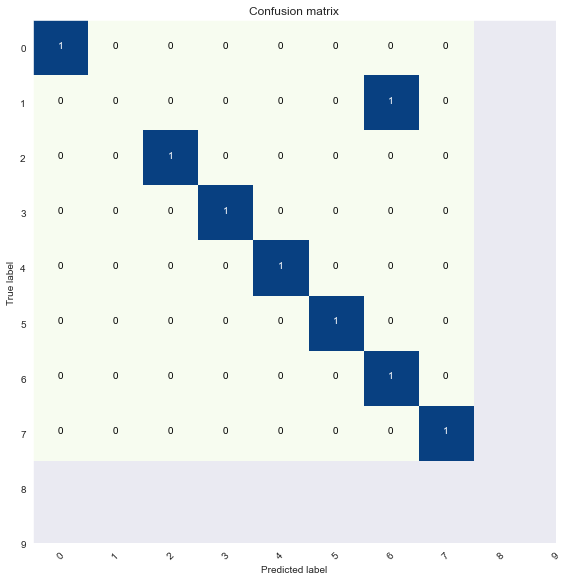

In [15]:
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")
plt.figure(figsize=(8,8))
plt.grid(False)
# call pre defined function
plot_confusion_matrix(cnf_matrix, classes=range(10))